《CUDA C编程权威指南》

# 2. CUDA编程模型

## 2.1 CUDA编程模型概述
### 2.1.1 编程结构
- 每个GPU和CPU的内存都由一条PCI-Express总线分隔开
- 主机
  - CPU及其内存
  - 串行执行
  - 代码使用CUDA C编写，nvcc编译
- 设备
  - GPU及其内存
  - 并行执行
  - 代码使用ANSI C编写，nvcc编译
- 编程模式
  - 数据：CPU->GPU（同步）
  - 计算：调用GPU执行kernel（异步）
  - 数据：GPU->CPU

### 2.1.2 内存管理
相关函数
- 内存申请：malloc、cudaMalloc
  - 申请一定字节的线性内存
- 内存拷贝：memcpy、cudaMemcpy
  - 同步拷贝数据（执行kernel是异步的）
    - cudaMemcpyHostToHost
    - cudaMemcpyHostToDevice
    - cudaMemcpyDeviceToHost
    - cudaMemcpyDeviceToDevice
- 内存填充：memset、cudaMemset
- 内存释放：free、cudaFree

内存层次结构
- 一级：GPU的共享内存，CPU的缓存
- 二级：GPU的全局内存，CPU的系统内存

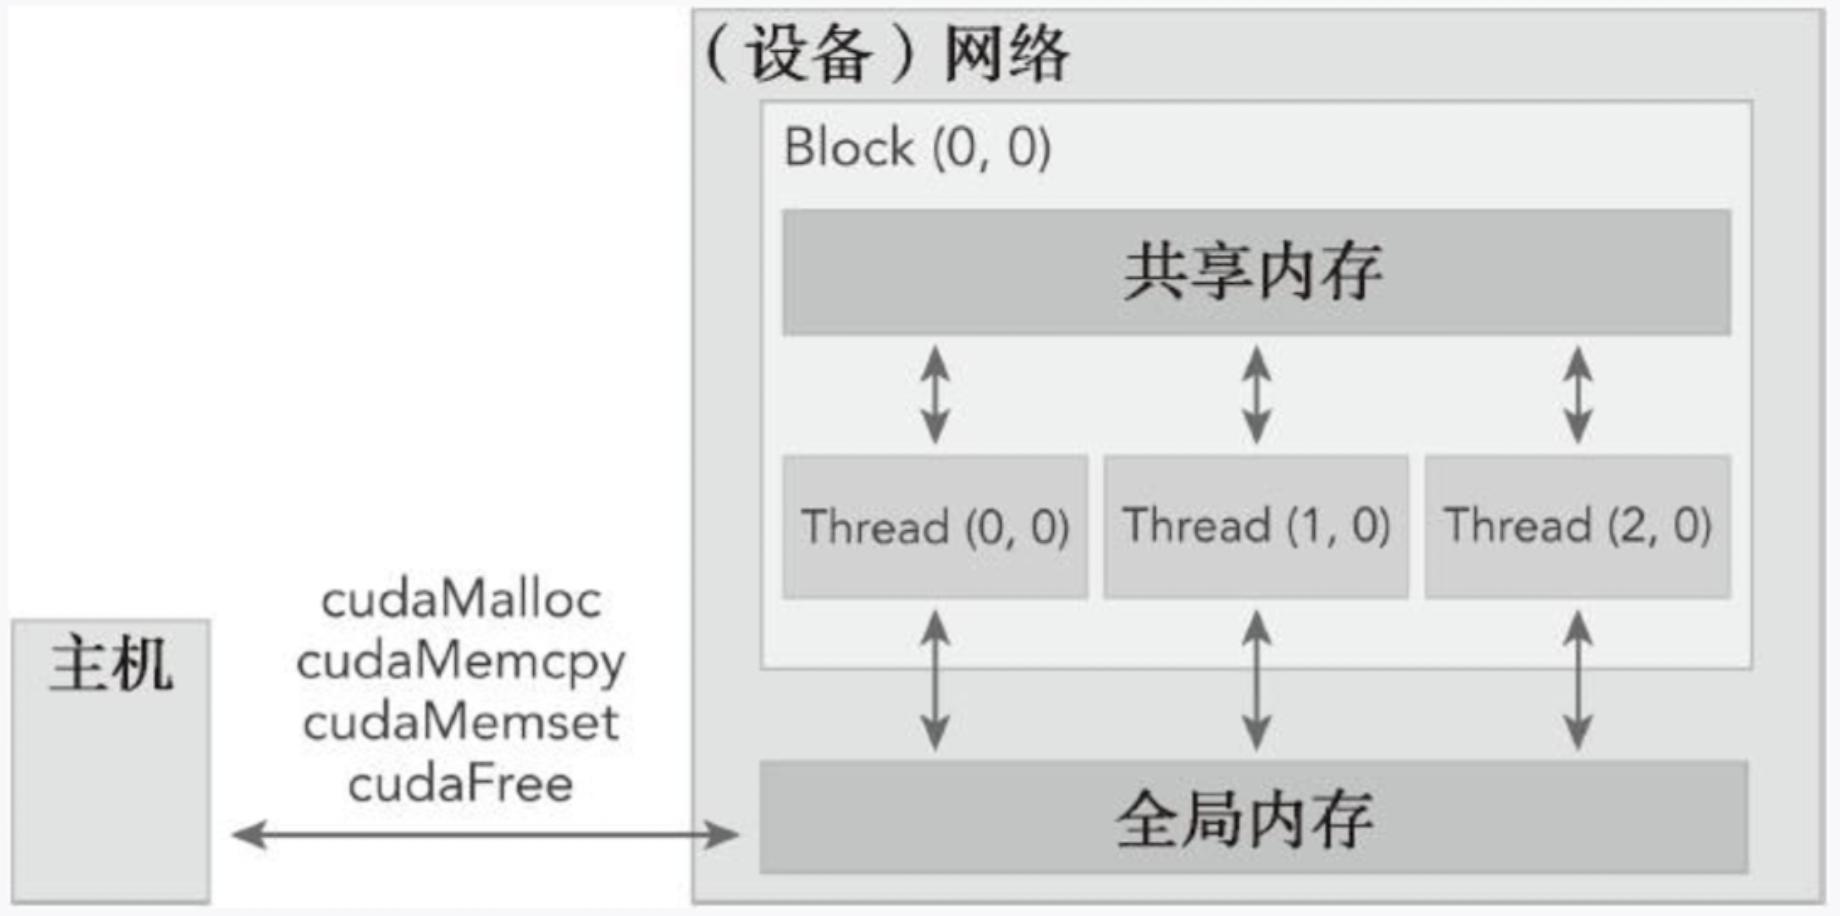

错误判断
- 除了内核启动之外的CUDA调用都会返回一个错误枚举cudaError_t
- 可通过cudaGetErrorString将cudaError_t转为可读错误消息

常见错误
- 不同内存空间的不恰当引用
    - gpuRef = d_C ❌
    - cudaMemcpy(gpuRef, d_C, nBytes, cudaMemcpyDeviceToHost) ✅
    - 为避免这种错误，CUDA 6.0提出统一寻址，使用一个指针访问GPU和CPU的内存

### 2.1.3 线程管理
grid
- 定义：一个kernel启动产生的所有block
- 内存共享：全局内存空间
- 协作：无法协作

block
- 定义：一组线程组成的线程组
- 内存共享：共享内存
- 协作：同步、共享内存

block和线程的索引
- 用途：定位、区分线程
- blockIdx：block在grid的索引
- threadIdx：thread在block的索引

grid和block的维度
- gridDim：grid维度，表示x、y、z维度上的block数量
- blockDim：block维度，表示x、y、z维度上的线程数量

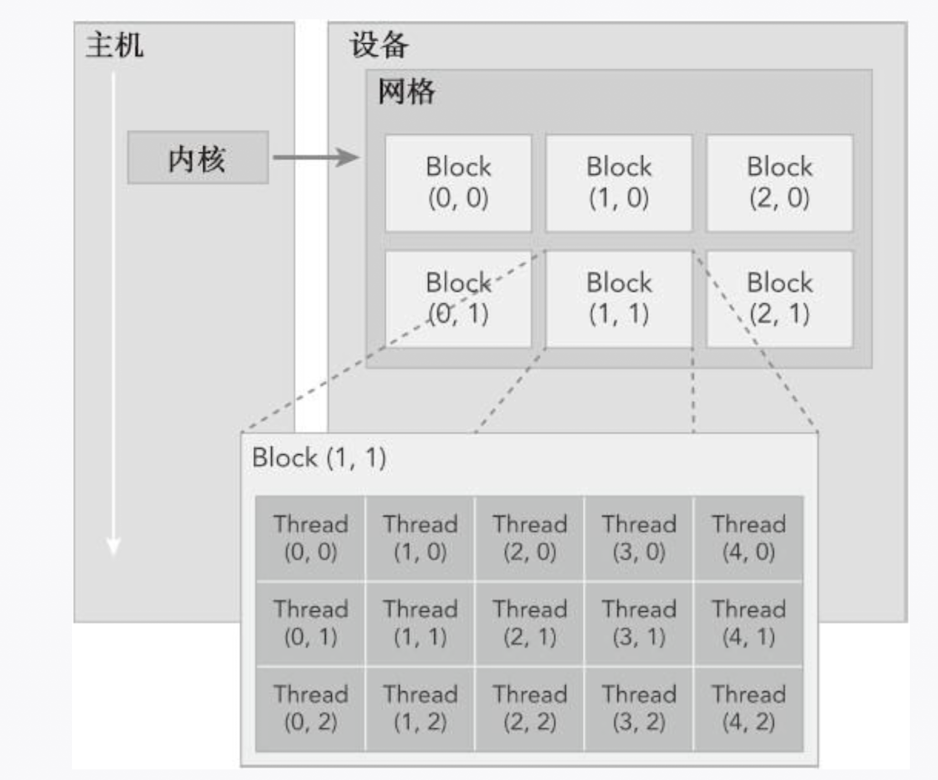

📌 调用kernel时，CUDA会生成相应的索引和维度

### 2.1.4 启动一个CUDA kernel

CUDA kernel是对C函数的拓展，增加了<<<>>>执行配置：```kernel_name <<<grid, block>>> (argument list)```，其中grid是grid维度，即block数目，block是block维度，即每个block的线程数。

例如```kernel_name<<<4, 8>>>(argument list)```对应的线程布局如下：

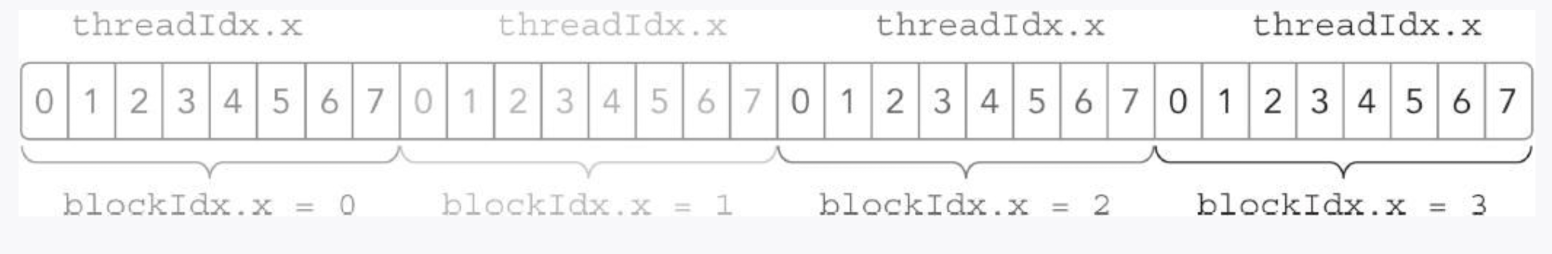

利用blockIdx.x和threadIdx.x可以
- 在grid中唯一表示线程
- 建立线程和数据的映射

CUDA kernel的调用是异步的，可以通过```cudaError_t cudaDeviceSynchronize(void)```等待所有CUDA kernel执行结束。

### 2.1.5 编写CUDA kernel
根据执行、调用限定，函数分为
- \_\_global__：在设备端执行，在主机端调用
- \_\_device__：在设备端执行，在设备端调用
- \_\_host__：在主机端执行，在主机端调用

📌 __device__函数通常用来抽离通用代码、复用代码；__device__和__host__可同时使用，允许相同的代码在两种不同的执行环境中使用

在设备端执行的CUDA kernel
- 只允许访问设备内存
- 必须返回void
- 不支持可变参数：违反SIMT执行相同指令的原则
- 不支持静态变量：并发不安全、初始化复杂
- 异步执行

### 2.1.6 验证CUDA kernel
- 分别在device端和host端执行，对比计算结果，误差不大于1.0E-8
- 将执行参数设置为<<<1, 1>>>，模拟串行执行，有助于调试和验证